Modifications:

1. Turn different models into another file, and VWAP should import the models to read models.
2. Rewrite VWAP LSTM factor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
import keras
import pickle

Using TensorFlow backend.


In [2]:
import os

data_dir="./data/"
ticker="TSLA"

date_pool=pd.date_range("1/1/2019","1/31/2019",freq="B").strftime("%Y%m%d")
date_pool=[d for d in date_pool if os.path.exists(data_dir+"trades_{}_{}.csv".format(d,ticker))]

train_days=10
train_date_list=date_pool[:train_days]
test_date_list=date_pool[train_days+1:]
time_steps = 50

nforward=10

## Utils

In [3]:
class Pipeline():
    def __init__(self):
        self.x = None
        self.y = None
        self.scaler = None
    def load_data(self, ticker, date):
        df = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(date, ticker),index_col=[0],parse_dates=[0])

        # Feature Engineering
        df["direction"]=(df["trade_px"]-df["trade_px"].shift(1)).apply(np.sign)
        df["pct_change"]=df["trade_px"].pct_change()

        mysign=lambda x: 0 if abs(x)<1e-3 else (1 if x>0 else -1)
        df["label"]=(df["trade_px"].rolling(nforward).mean().shift(-nforward)-df["trade_px"]).apply(mysign)
        # df["label"]=(df["trade_px"].shift(-1)-df["trade_px"]).apply(np.sign) # last version

        df.fillna(method="ffill",inplace=True)
        df.dropna(axis=0,inplace=True)
        # print(df.head(10),df.shape)
        # print("NaN number: ",df.isna().sum().sum())
        
        
        # trade_px removed
        return df[["trade_size","pct_change","direction","label"]].values

    def create_dataset(self, ticker=ticker, dates=train_date_list, time_steps = time_steps, input_scaler=None):  
        for i,d in enumerate(dates):
            datanew = self.load_data(ticker,d)
            if i==0:
                data=datanew
            else:
                data=np.vstack((data, datanew))
        
        label=data[:,-1]
        data=data[:,:-1]

        if input_scaler is None:
            scaler=StandardScaler()
            data=scaler.fit_transform(data)
        else:
            data=input_scaler.transform(data)
            scaler=input_scaler

        x = [data[0 : time_steps]]
        y = [label[time_steps-1]]
        N=len(data)//time_steps

        print(N)
        for i in range(1, N):
            t = data[i*time_steps: (i + 1)*time_steps]
            x = np.vstack((x, [t]))
            y.append(label[(i + 1)*time_steps-1])

        y=pd.get_dummies(y)
        #print(y)

        return x,y.values,scaler

    def loss_plot(self, history, plot_name = 'Loss'): # type(history) is dict
        loss = np.asarray(history['loss'])
        val_loss = np.asarray(history['val_loss'])

        plt.style.use('seaborn')
        plt.figure(figsize = (20,6), dpi=dpi)
        plt.grid(True)
        plt.plot(loss, color = 'darkgrey')
        plt.plot(val_loss, color = 'tan')
        plt.legend(['loss', 'val_loss'])
        # plt.savefig('{}_{}_{}_{}_{}.png'.format(ticker, plot_name, str(n_epochs), str(time_steps), str(batch_size)))
    
    
    def training_data_transform(self, ticker):
        # Load train data
        x, y, scaler = self.create_dataset(ticker)
        self.x, self.y, self.scaler = x, y, scaler
        print("Finished loading data.")

        with open("model/scaler_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"wb") as f:
            pickle.dump(scaler,f)

    def model_training_testing(self, ticker, model, plot = False):
        # Model Training pipeline
        model_functionalities = Model_Functionalities(model)
        
        x, y, scaler = self.x, self.y, self.scaler
        print(y[:10])
        
        if x is None:
            print("None Training data processed")
            return
        
        # Build model, in-sample train test
        train_history = model_functionalities.train_test(x, y, plot)  
        if model_functionalities.model.model_name == "LSTM":
            if plot == True:
                self.loss_plot(train_history.history)

        with open("model/" + model.model_name + "_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"wb") as f:
            pickle.dump(model_functionalities.model,f)

        # Out-of-sample test
        for test_date in test_date_list:
            # create test dateset
            x_test, y_test, _ = self.create_dataset(ticker=ticker, dates=[test_date], time_steps = time_steps, input_scaler=scaler)
            x_test, y_test = model_functionalities.model.reshape_dataset(x_test, y_test)

            # use precious trained model to test
            y_test_pred = model_functionalities.predict(x_test)
            if model_functionalities.model.model_name == "LSTM":
                if plot == True:
                    model_functionalities.view_accuracy(y_test_pred.argmax(axis=1), y_test.argmax(axis=1))
            if y_test.shape[1] != 1:
                accuracy = np.mean(y_test_pred.argmax(axis=1)==y_test.argmax(axis=1))
            else:
                accuracy = np.mean(y_test_pred==y_test)
            print(test_date+" accuracy: ", accuracy)
        return model_functionalities.model

In [4]:
class Model_Functionalities():
    def __init__(self, model):
        self.model = model
    def train_test(self, x, y, plot = False):
        
        size = len(x)
        if size!=len(y):
            return None
        x = x[: batch_size * (size // batch_size)]
        y = y[: batch_size * (size // batch_size)]
        
        x, y = self.model.reshape_dataset(x, y)

        x_train, x_validation, y_train, y_validation= train_test_split(x, y, test_size = 0.1, shuffle = True)
        print('train', x_train.shape, y_train.shape)
        print('validation', x_validation.shape, y_validation.shape)
        
        
        if self.model.model_name == "LSTM" or  self.model.model_name == "CNN":
            early_stopping = EarlyStopping(monitor='val_loss', patience=stop_patience, mode="min", verbose=2, restore_best_weights=True)
            history = self.model.fit(x_train, y_train, batch_size = batch_size, epochs = n_epochs,
                                     validation_data=(x_validation, y_validation),callbacks=[early_stopping])
        else:
            self.model.fit(x_train, y_train)
        
        self.y_pred = self.model.predict(x_validation)
        self.y_validation_true = y_validation
        
        if plot == True:
            if y.shape[1] != 1:
                self.train_plot = self.view_accuracy(self.predict(x_train).argmax(axis=1), y_train.argmax(axis=1), 'Train')
                self.validation_plot = self.view_accuracy(self.predict(x_validation).argmax(axis=1), y_validation.argmax(axis=1), 'Validation')
            else:
                self.train_plot = self.view_accuracy(self.predict(x_train), y_train, 'Train')
                self.validation_plot = self.view_accuracy(self.predict(x_validation), y_validation, 'Validation')
        if self.model.model_name == "LSTM":
            return history

    def predict(self, x_validation):
        pred = self.model.predict(x_validation)
        return pred
    
    def view_accuracy(self, y_pred = None, y_true = None, plot_name = 'Test', num=100):
        if y_pred is None:
            y_pred = self.y_pred.argmax(axis=1)
            y_true = self.y_validation_true.argmax(axis=1)
        
        plt.style.use('seaborn')
        plt.figure(figsize = (20,6), dpi=dpi)
        plt.grid(True)
        plt.plot(y_pred[:num], color = 'lightcoral')
        plt.plot(y_true[:num], color = 'cornflowerblue', linewidth = 1)
        plt.title('{}_{}'.format(ticker, plot_name))
        plt.legend(['predict', 'true'])

## Training Data

In [5]:
pipeline = Pipeline()
pipeline.training_data_transform(ticker)

15154
Finished loading data.


In [6]:
labels = pipeline.y.argmax(axis = 1) - 1
print("positive", (labels == 1).mean())
print("neutral", (labels == 0).mean())
print("negative", (labels == -1).mean())

positive 0.4660815626237297
neutral 0.057146627953015706
negative 0.4767718094232546


In [7]:
from models import *

# Using LSTM to predict next up and down
## v2: Predict up and downs of the average of $\mathbf{nforward}=10$ following prices

1. Too slow to predict (next trade may happen in millisecond)
2. Only classification of up, down and same. No quantitative prediction (can be improved to predict quantity of price movement)

In [8]:
hidden_dim = 30
n_epochs = 100
batch_size = 128
activation = "tanh"
loss = 'categorical_crossentropy'
stop_patience=20

dpi=200

In [9]:
lstm_model = LSTM_Model(time_steps = time_steps,  hidden_dim = hidden_dim, n_epochs = n_epochs,
                        activation = activation, loss = loss, 
                        data_dim = pipeline.x.shape[-1], output_dim = pipeline.y.shape[-1])
lstm_model.build()
pipeline.model_training_testing(ticker, lstm_model)

[[1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]]
train (13593, 50, 3) (13593, 3)
validation (1511, 50, 3) (1511, 3)
Train on 13593 samples, validate on 1511 samples
Epoch 1/100
13593/13593 [==============================] - 10s 742us/step - loss: 0.8859 - accuracy: 0.5092 - val_loss: 0.8244 - val_accuracy: 0.5480
Epoch 2/100
13593/13593 [==============================] - 9s 648us/step - loss: 0.8165 - accuracy: 0.5648 - val_loss: 0.7988 - val_accuracy: 0.5612
Epoch 3/100
13593/13593 [==============================] - 9s 649us/step - loss: 0.8007 - accuracy: 0.5759 - val_loss: 0.7956 - val_accuracy: 0.5645
Epoch 4/100
13593/13593 [==============================] - 9s 641us/step - loss: 0.7961 - accuracy: 0.5751 - val_loss: 0.7913 - val_accuracy: 0.5632
Epoch 5/100
13593/13593 [==============================] - 9s 646us/step - loss: 0.7928 - accuracy: 0.5824 - val_loss: 0.7885 - val_accuracy: 0.5692
Epoch 6/100
13593/13593 [======================

In [10]:
print(pipeline.x.shape, pipeline.y.shape)

(15154, 50, 3) (15154, 3)


# CNN

In [11]:
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras import regularizers

In [12]:
hidden_dim = 30
n_epochs = 100
batch_size = 128
activation = "relu"
loss = 'categorical_crossentropy'
stop_patience=20

dpi=200

In [13]:
cnn_model = CNN_Model(time_steps = time_steps, hidden_dim = hidden_dim, n_epochs=n_epochs,
                      activation = activation, loss = loss,
                      data_dim = pipeline.x.shape[-1], output_dim = pipeline.y.shape[-1])
cnn_model.build()
pipeline.model_training_testing(ticker, cnn_model)

[[1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]]
train (13593, 50, 3, 1) (13593, 3)
validation (1511, 50, 3, 1) (1511, 3)
Train on 13593 samples, validate on 1511 samples
Epoch 1/100
13593/13593 [==============================] - 6s 409us/step - loss: 0.8656 - accuracy: 0.5373 - val_loss: 0.8400 - val_accuracy: 0.5414
Epoch 2/100
13593/13593 [==============================] - 5s 382us/step - loss: 0.8178 - accuracy: 0.5659 - val_loss: 0.8231 - val_accuracy: 0.5612
Epoch 3/100
13593/13593 [==============================] - 5s 390us/step - loss: 0.8006 - accuracy: 0.5802 - val_loss: 0.8189 - val_accuracy: 0.5619
Epoch 4/100
13593/13593 [==============================] - 5s 391us/step - loss: 0.7887 - accuracy: 0.5932 - val_loss: 0.8148 - val_accuracy: 0.5797
Epoch 5/100
13593/13593 [==============================] - 5s 389us/step - loss: 0.7787 - accuracy: 0.5949 - val_loss: 0.8302 - val_accuracy: 0.5652
Epoch 6/100
13593/13593 [=================

# Random Forest

In [14]:
max_depth=30
n_estimators=100
max_features=0.3
criterion = 'gini'

In [15]:
random_forest_model = RandomForest(max_depth, n_estimators, max_features, criterion)
pipeline.model_training_testing(ticker, random_forest_model)

[[1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]]
train (13593, 150) (13593, 3)
validation (1511, 150) (1511, 3)
808
20190117 accuracy:  0.5693069306930693
5342
20190118 accuracy:  0.5847997004867092
2570
20190122 accuracy:  0.5743190661478599
2944
20190123 accuracy:  0.5842391304347826
1759
20190124 accuracy:  0.5815804434337691
1610
20190125 accuracy:  0.5670807453416149
1428
20190128 accuracy:  0.5903361344537815
1034
20190129 accuracy:  0.5667311411992263
2164
20190130 accuracy:  0.5480591497227357
2679
20190131 accuracy:  0.555431131019037


# GradientBoost

In [16]:
n_estimators=30
max_depth=30
learning_rate=0.05

In [17]:
gradient_boost_model=GradientBoost(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate)
pipeline.model_training_testing(ticker, gradient_boost_model)

[[1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]]
train (13593, 150) (13593, 1)
validation (1511, 150) (1511, 1)


/usr/local/share/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


808
20190117 accuracy:  0.46700078423683955
5342
20190118 accuracy:  0.43066150975275436
2570
20190122 accuracy:  0.44654423231237417
2944
20190123 accuracy:  0.44813384721319705
1759
20190124 accuracy:  0.45929760727013935
1610
20190125 accuracy:  0.46287257436055707
1428
20190128 accuracy:  0.4647996453483354
1034
20190129 accuracy:  0.46313914901099557
2164
20190130 accuracy:  0.46121481237251477
2679
20190131 accuracy:  0.46323909811857006


# XGBOOST

In [18]:
n_estimators=30
max_depth=30
learning_rate=0.05
reg_lambda=0.1
verbose=False

In [19]:
xgboost_model=XGBoost(n_estimators=n_estimators, max_depth=max_depth,learning_rate=learning_rate,reg_lambda=reg_lambda, verbose=verbose)
pipeline.model_training_testing(ticker, xgboost_model)

[[1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]]
train (13593, 150) (13593, 1)
validation (1511, 150) (1511, 1)


/usr/local/share/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/share/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


808
20190117 accuracy:  0.4654629448093324
5342
20190118 accuracy:  0.42616828475516877
2570
20190122 accuracy:  0.4406003118896577
2944
20190123 accuracy:  0.4445616175862476
1759
20190124 accuracy:  0.45679508713572786
1610
20190125 accuracy:  0.46114656070367654
1428
20190128 accuracy:  0.4619627262669774
1034
20190129 accuracy:  0.4600600847771513
2164
20190130 accuracy:  0.4609771389328313
2679
20190131 accuracy:  0.4616508391132223


#  Tick Factor

In [20]:
# TICK FACTOR
# only update if it's a trade
# if message_type == 't':
#     # calc the tick
#     this_tick = np.sign(last_price - prev_price)
#     if this_tick == 0:
#         this_tick = prev_tick

#     # now calc the tick
#     if tick_factor == 0:
#         tick_factor = this_tick
#     else:
#         tick_factor = (tick_ema_alpha * this_tick) + (1 - tick_ema_alpha) * tick_factor

#         # store the last tick
#     prev_tick = this_tick

for test_date in test_date_list:
    df = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(test_date, ticker),index_col=[0],parse_dates=[0])
    
    df["tick_test"]=(df["trade_px"]-df["trade_px"].shift(1)).apply(lambda x: 1 if x>0. else (-1. if x<0 else np.nan))
    df.fillna(method="ffill",inplace=True)
    
    df["tick_factor"]=df["tick_test"].ewm(span=20).mean()
    df.dropna(axis=0,inplace=True)
    
    mysign = lambda x: 0 if abs(x)<1e-5 else (1 if x>0 else -1)
    df["predict"]=df["tick_factor"].apply(mysign)
    df["real_movement"]=(df["trade_px"].rolling(nforward).mean().shift(-nforward)-df["trade_px"]).apply(mysign)
    
    df.dropna(axis=0,inplace=True)
    acc=np.mean(df["predict"]==df["real_movement"])
    print("Accuracy of {}".format(test_date),acc)


Accuracy of 20190117 0.4707643580036127
Accuracy of 20190118 0.43095347731518396
Accuracy of 20190122 0.4555151005928208
Accuracy of 20190123 0.45868338302510847
Accuracy of 20190124 0.4674517203359969
Accuracy of 20190125 0.463677230280151
Accuracy of 20190128 0.48354217710885544
Accuracy of 20190129 0.45997873779839565
Accuracy of 20190130 0.45219857893910137
Accuracy of 20190131 0.4725264061508603


Average time interval between 10 trades is 0 days 00:00:02.094658


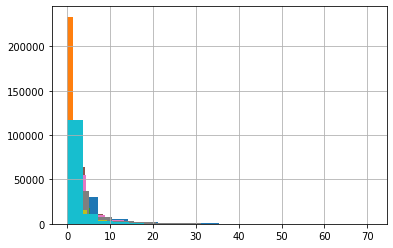

In [21]:
sum=pd.Timedelta(0)
count=0
for test_date in test_date_list:
    df = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(test_date, ticker),index_col=[0],parse_dates=[0])
    timestamp=pd.DataFrame({"trade_time":df.index})
    dt=timestamp["trade_time"].shift(-nforward)-timestamp["trade_time"]
    dt.dropna(axis=0,inplace=True)
    dt.apply(lambda x:x.seconds).hist()
    sum+=dt.sum()
    count+=dt.shape[0]
print("Average time interval between {} trades is".format(nforward),sum/count)